In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
import torch
import scipy.stats.distributions as dist
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [3]:
SIGMA = 0.1

class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(8.00, 0.001)])
        self.bounds = bounds
        self.Npix = Npix
#        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler2((Npix, Npix))
        self.sigma = torch.ones(Npix, Npix)*SIGMA
        self.sigma[:,:Npix//2] *= 1

    def get_pk_fn(self, theta):
        return lambda k: 1e-7*(k+0.05)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
        kernel = torch.ones(1, 1, 3, 3)/3**2
        return torch.nn.functional.conv2d(rho.unsqueeze(0).unsqueeze(0), kernel, padding = 1).squeeze(0).squeeze(0)
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
#        rho = graph.node('rho', lambda delta: self.psf(np.exp(delta*0.5)-1)*2.0, delta)
        rho = graph.node('rho', lambda delta: self.psf(delta), delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


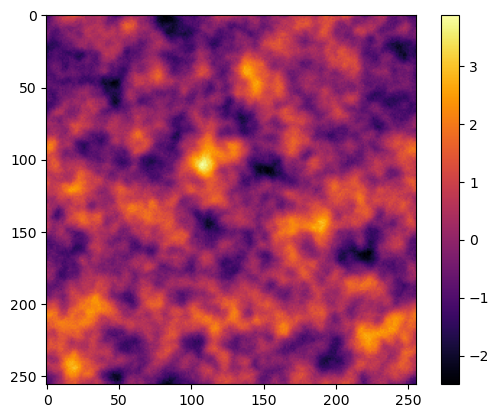

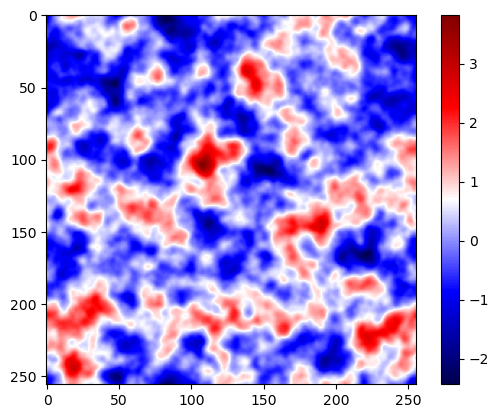

0.15957455


0.8604858

In [4]:
NPIX = 256
#bounds = torch.stack(s).cpu().float()
bounds = None
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
sample0 = sim.sample(conditions = dict(theta = np.array([8.0])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'],cmap = 'seismic')
plt.colorbar()
plt.show()
print(sample0['delta'].mean())
sample0['delta'].std()

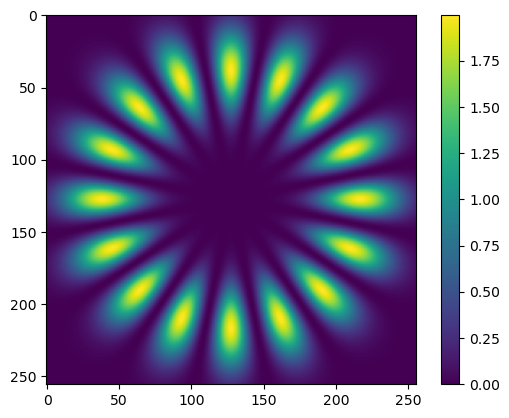

In [5]:
def gen_target_image(Npix):
    l = torch.linspace(-1, 1, Npix)
    L1, L2 = torch.meshgrid(l, l)
    R = (L1**2+L2**2)**0.5
    t = torch.exp(-(R-0.7)**2/2/0.15**2)
    t *= torch.cos(torch.arctan2(L1, L2)*16)+1
    return t

mu0 = gen_target_image(Npix = NPIX)
#torch.save(mu0, 'step2_target_image.pt')
#mu0 = torch.load("step2_target_image.pt")
plt.imshow(mu0)
plt.colorbar()

In [6]:
def hook(sample):
    sample['x'] = sample['rho'] + np.random.randn(*sample['delta'].shape)* sim.sigma.numpy()
    return sample

In [ ]:
samples = sim.sample(64*32, exclude = ['pk_fn'])
pk0 = sim.sample()['pk_fn']

In [185]:
class SymMat(torch.nn.Module):
    """Parametrization of a symmetric positive definite matrix.
    
    Q = G_T * D * G
    
    Input and output shapes are (B, NX, NY), where shape = (NX, NY).
    """
    def __init__(self, shape, k = 1):
        super().__init__()
        assert len(shape) == 2
        self._shape = shape
        
        self._conv1 = torch.nn.Conv2d(1, 1, 2*k+1, padding = k, bias = False)
        self._conv1.weight = torch.nn.Parameter(torch.ones_like(self._conv1.weight))
        self._conv1T = torch.nn.ConvTranspose2d(1, 1, 2*k+1, padding = k, bias = False)
        self._logD = torch.nn.Parameter(-3*torch.ones(shape[0]*shape[1]))

    def G(self, x):
        x = self._conv1(x.unsqueeze(1)).squeeze(1)
        x = x.flatten(1, 2)
        return x
    
    @property
    def D(self):
        return torch.exp(self._logD)
    
    def G_T(self, x):
        self._conv1T.weight = self._conv1.weight
        x = x.unflatten(1, self._shape)
        x = self._conv1T(x.unsqueeze(1)).squeeze(1)
        return x
    
    def __call__(self, x):
        """(B, NX, NY) --> (B, NX, NY)"""
        x = self.G(x)
        x = self.D*x
        x = self.G_T(x)
        return x

In [186]:
# Test symmetry
x1 = torch.randn(1, 4, 4)
x2 = torch.randn(1, 4, 4)
SM = SymMat((4, 4,))
(x1*SM(x2)).sum(), (x2*SM(x1)).sum()

(tensor(2.0662, grad_fn=<SumBackward0>),
 tensor(2.0662, grad_fn=<SumBackward0>))

In [187]:
class SlicedScoreMatching(torch.nn.Module):
    def __init__(self, Q_like, Q_prior = None):
        super().__init__()
        self.Q_like = Q_like
        self.Q_prior = Q_prior if Q_prior else lambda x: x*0

    def __call__(self, b, z):
        N = torch.randn_like(z)*z.std()
#        print(z.shape, self.Q_like(z).shape, self.Q_prior(z).shape, b.shape, N.shape)
        loss = 0.5*((self.Q_like(z)+self.Q_prior(z)-b)*N)**2 - (self.Q_like(N)+self.Q_prior(N))*N
#        loss = 0.5*((self.Q_prior(z)-b)*N)**2 - (self.Q_like(N)+self.Q_prior(N))*N
        loss = loss.reshape(-1)
        return swyft.AuxLoss(loss, 'x')

In [188]:
class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 3e-3
        self.early_stopping_patience = 10000
        UT, D, U = sim.powersampler.covariance_decomposition(pk0)
        self.D = torch.nn.Parameter(D, requires_grad = False)
        prior_Q = lambda x: UT(U(x)/self.D)
        self.Q_like = SymMat((NPIX, NPIX))
        self.L = SlicedScoreMatching(Q_like = self.Q_like, Q_prior = prior_Q)
        
        self.receptor = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 1, 9, padding=4),
            torch.nn.Flatten(0, 1)
        )
        self.map1 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
#            torch.nn.Conv2d(1, 1, 1, padding=0),
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 3, padding=1),
            torch.nn.Flatten(0, 1)
        )
        self.map2 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 3, padding=1),
            torch.nn.Flatten(0, 1)
        )
        self.map3 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 64, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 1, 1, padding=0),
            torch.nn.Flatten(0, 1)
        )
        
    def estimator1(self, x):
#        x = self.receptor(x)
        x = self.map1(x)# + x
        x = self.map2(x)# + x
        return x

    def forward(self, A, B):
        x = A['x']
        b = self.estimator1(x)
        z = B['delta'][:len(x)]
        return self.L(b, z)

In [189]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 5)
dm = swyft.SwyftDataModule(samples, batch_size=64, on_after_load_sample=hook)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                | Params
-------------------------------------------------
0 | Q_like   | SymMat              | 65.6 K
1 | L        | SlicedScoreMatching | 65.6 K
2 | receptor | Sequential          | 82    
3 | map1     | Sequential          | 2.6 K 
4 | map2     | Sequential      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4574016/checkpoints/epoch=3-step=104-v1.ckpt


In [190]:
network.cuda()

#pk = sim.sample()['pk_fn']
U2T, invD2, U2 = sim.powersampler.covariance_decomposition(pk0)
D2 = 1/invD2

GAMMA = 1
x = mu0.cuda().double()
d = torch.tensor(samples[i]['delta']).double()
x = x.cuda()
mu = network.estimator1(x.unsqueeze(0)).squeeze(0).cpu().detach() * GAMMA

G1 = lambda x: network.L.Q_like.G(x.unsqueeze(0)).squeeze(0).detach()
G1T = lambda x: network.L.Q_like.G_T(x.unsqueeze(0)).squeeze(0).detach()

D1 = network.L.Q_like.D.detach().cpu()*GAMMA
print(D1.mean())

tensor(0.0498, dtype=torch.float64)


In [191]:
mu = mu.cuda().detach()
D1 = D1.cuda()
D2 = D2.cuda()
sampler = swyft.utils.GEDASampler2(1e-2, G1, D1, G1T, U2, D2, U2T, out_shape = (NPIX, NPIX), mu = mu)
s = sampler.sample(1, steps=1000, initialize_with_Q2=True, reset = True)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.5501, device='cuda:0', dtype=torch.float64)

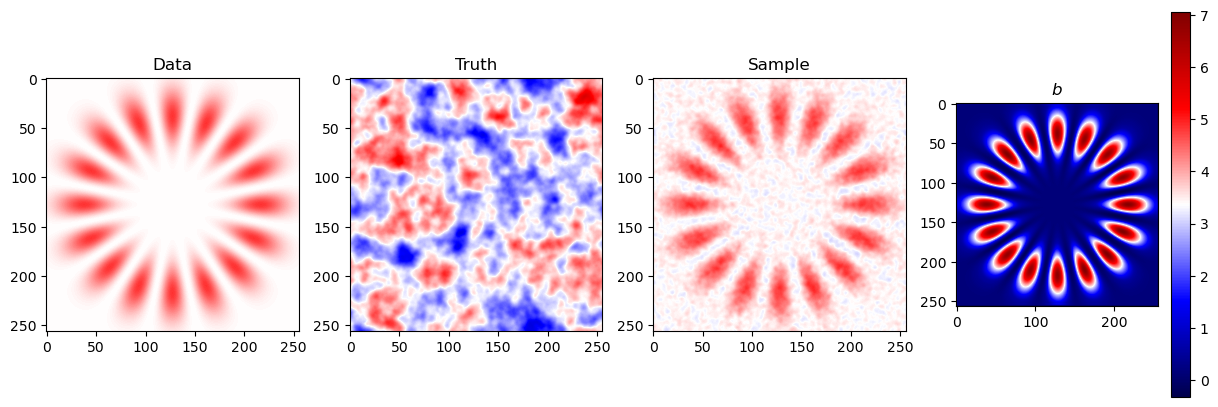

In [192]:
plt.figure(figsize = (15, 5))
plt.subplot(141)
plt.title("Data")
plt.imshow(x.cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(142)
plt.title("Truth")
plt.imshow(d, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(143)
plt.title("Sample")
plt.imshow(s[0].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(144)
plt.title("$b$")
plt.imshow(mu.cpu(), cmap = 'seismic')#, vmin = -5, vmax = 5)
plt.colorbar()
s[0].std()/d.std()

IndexError: list index out of range

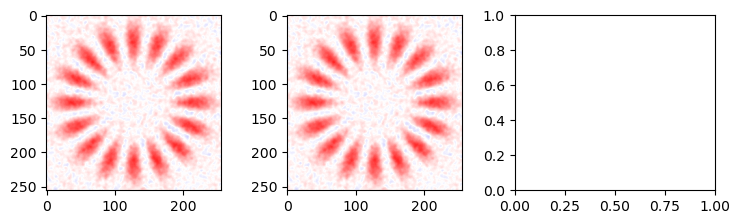

In [193]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s[i-1].cpu(), vmin = -5, vmax = 5, cmap = 'seismic')

In [107]:
sampler = swyft.utils.GEDASampler2(1e-2, G1, D1, G1T, U2, D2, U2T, out_shape = (NPIX, NPIX), mu = mu)
s = sampler.sample(2048, steps=20, initialize_with_Q2=True)

  0%|          | 0/2048 [00:00<?, ?it/s]